In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [5]:
import tensorflow.compat.v1 as tf

In [6]:
tf.disable_v2_behavior()

In [9]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

%matplotlib inline
np.random.seed(0)
tf.random.set_seed(123456)

In [34]:
### Utility Functions
## Plots
# Plot Feature Projection [credit: https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders]
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
## Util methods copied from OCAN package due to failure to install as custom package [credit:https://github.com/PanpanZheng/OCAN]
def xavier_init(size): # initialize the weight-matrix W.
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)

def sample_shuffle_uspv(X):
    n_samples = len(X)
    s = np.arange(n_samples)
    np.random.shuffle(s)
    return np.array(X[s])

def pull_away_loss(g):

    Nor = tf.norm(g, axis=1)
    Nor_mat = tf.tile(tf.expand_dims(Nor, axis=1),
                      [1, tf.shape(g)[1]])
    X = tf.divide(g, Nor_mat)
    X_X = tf.square(tf.matmul(X, tf.transpose(X)))
    mask = tf.subtract(tf.ones_like(X_X),
                       tf.linalg.diag(
                           tf.ones([tf.shape(X_X)[0]]))
                       )
    pt_loss = tf.divide(tf.reduce_sum(tf.multiply(X_X, mask)),
                        tf.multiply(
                            tf.cast(tf.shape(X_X)[0], tf.float32),
                            tf.cast(tf.shape(X_X)[0]-1, tf.float32)))

    return pt_loss

def one_hot(x, depth):
    x_one_hot = np.zeros((len(x), depth), dtype=np.int32)
    x = x.astype(int)
    for i in range(x_one_hot.shape[0]):
        x_one_hot[i, x[i]] = 1
    return x_one_hot

def sample_Z(m, n):   # generating the input for G.
    return np.random.uniform(-1., 1., size=[m, n])

def draw_trend(D_real_prob, D_fake_prob, D_val_prob, fm_loss, f1):

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(311)
    p1, = plt.plot(D_real_prob, "-g")
    p2, = plt.plot(D_fake_prob, "--r")
    p3, = plt.plot(D_val_prob, ":c")
    plt.xlabel("# of epoch")
    plt.ylabel("probability")
    leg = plt.legend([p1, p2, p3], [r'$p(y|V_B)$', r'$p(y|\~{V})$', r'$p(y|V_M)$'], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.draw_frame(False)
    # plt.legend(frameon=False)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(312)
    p4, = plt.plot(fm_loss, "-b")
    plt.xlabel("# of epoch")
    plt.ylabel("feature matching loss")
    # plt.legend([p4], ["d_real_prob", "d_fake_prob", "d_val_prob"], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(313)
    p5, = plt.plot(f1, "-y")
    plt.xlabel("# of epoch")
    plt.ylabel("F1")
    # plt.legend([p1, p2, p3, p4, p5], ["d_real_prob", "d_fake_prob", "d_val_prob", "fm_loss","f1"], loc=1, bbox_to_anchor=(1, 3.5), borderaxespad=0.)
    plt.show()

## OCAN TF Training Utils
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.nn.tanh(tf.matmul(G_h1, G_W2) + G_b2)
    return G_logit


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.softmax(D_logit)
    return D_prob, D_logit, D_h2


# pre-train net for density estimation.
def discriminator_tar(x):
    T_h1 = tf.nn.relu(tf.matmul(x, T_W1) + T_b1)
    T_h2 = tf.nn.relu(tf.matmul(T_h1, T_W2) + T_b2)
    T_logit = tf.matmul(T_h2, T_W3) + T_b3
    T_prob = tf.nn.softmax(T_logit)
    return T_prob, T_logit, T_h2

In [12]:
raw_data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data, data_test = train_test_split(raw_data, test_size=0.25)

In [14]:
raw_data_sample = data[data['Class'] == 0].sample(1000).append(data[data['Class'] == 1]).sample(frac=1).reset_index(drop=True)
raw_data_x = raw_data_sample.drop(['Class'], axis = 1)
raw_data_x[['Time']]=MinMaxScaler().fit_transform(raw_data_x[['Time']])
raw_data_x[['Amount']]=MinMaxScaler().fit_transform(raw_data_x[['Amount']])

In [15]:
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
194763,12.318611,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,...,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.570980,0
135660,22.595556,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,...,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.026042,0
259186,20.167778,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,...,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,1.938742,0
87387,17.128333,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,...,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,2.322388,0
267282,21.195278,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,...,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,3.882182,0


In [16]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

In [17]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='sigmoid')(encoded) 

## decoding part
decoded = Dense(50, activation='tanh')(encoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded) 

# Autoencoder model
autoencoder = Model(input_layer, output_layer)

autoencoder.compile(optimizer="adadelta", loss="mse")

# Min-max scaling 
x = data.drop(["Class"], axis=1)
y = data["Class"].values

# x_scale = MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)
x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


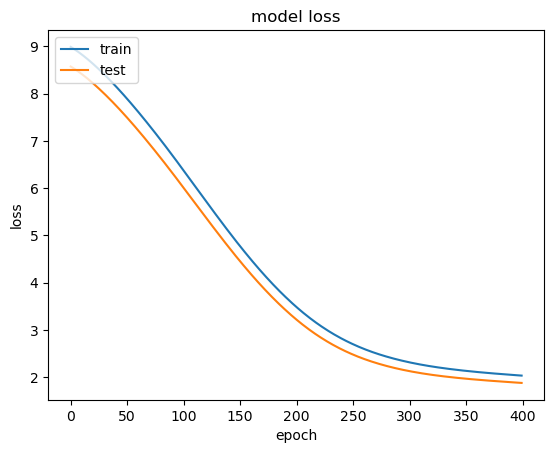

In [18]:
checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)
x_norm_train_sample = x_norm[np.random.randint(x_norm.shape[0], size=10000),:]
hist = autoencoder.fit(x_norm_train_sample, x_norm_train_sample, 
                batch_size = 256, epochs = 400, 
                shuffle = True, validation_split = 0.05, verbose=0, callbacks=[checkpointer, earlystopper])
plot_loss(hist)

In [19]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

norm_hid_rep = hidden_representation.predict(x_norm[np.random.randint(x_norm.shape[0], size=700),:])
fraud_hid_rep = hidden_representation.predict(x_fraud)

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [20]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [23]:
dim_input = norm_hid_rep.shape[1]
mb_size = 70

D_dim = [dim_input, 100, 50, 2]
G_dim = [50, 100, dim_input]
Z_dim = G_dim[0]

X_oc = tf.compat.v1.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.compat.v1.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.compat.v1.placeholder(tf.float32, shape=[None, dim_input])

# define placeholders for labeled-data, unlabeled-data, noise-data and target-data.

X_oc = tf.compat.v1.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.compat.v1.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.compat.v1.placeholder(tf.float32, shape=[None, dim_input])
# X_val = tf.placeholder(tf.float32, shape=[None, dim_input])

In [26]:
# declare weights and biases of discriminator.

D_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
D_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

D_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
D_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

D_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
D_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]


In [27]:
# declare weights and biases of generator.

G_W1 = tf.Variable(xavier_init([G_dim[0], G_dim[1]]))
G_b1 = tf.Variable(tf.zeros(shape=[G_dim[1]]))

G_W2 = tf.Variable(xavier_init([G_dim[1], G_dim[2]]))
G_b2 = tf.Variable(tf.zeros(shape=[G_dim[2]]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [28]:
# declare weights and biases of pre-train net for density estimation.

T_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
T_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

T_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
T_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

T_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
T_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_T = [T_W1, T_W2, T_W3, T_b1, T_b2, T_b3]

In [31]:
D_prob_real, D_logit_real, D_h2_real = discriminator(X_oc)

G_sample = generator(Z)
D_prob_gen, D_logit_gen, D_h2_gen = discriminator(G_sample)

D_prob_tar, D_logit_tar, D_h2_tar = discriminator_tar(X_tar)
D_prob_tar_gen, D_logit_tar_gen, D_h2_tar_gen = discriminator_tar(G_sample)
# D_prob_val, _, D_h1_val = discriminator(X_val)

# disc. loss
y_real= tf.compat.v1.placeholder(tf.int32, shape=[None, D_dim[3]])
y_gen = tf.compat.v1.placeholder(tf.int32, shape=[None, D_dim[3]])

D_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_real, D_logit_real))
D_loss_gen = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_gen, D_logit_gen))


In [35]:
ent_real_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_real, tf.math.log(D_prob_real)), 1
                        )
                    )

ent_gen_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_gen, tf.math.log(D_prob_gen)), 1
                        )
                    )

D_loss = D_loss_real + D_loss_gen + 1.85 * ent_real_loss


# gene. loss
pt_loss = pull_away_loss(D_h2_tar_gen)

In [37]:

y_tar= tf.compat.v1.placeholder(tf.int32, shape=[None, D_dim[3]])
T_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=D_logit_tar, labels=y_tar))
tar_thrld = tf.divide(tf.reduce_max(D_prob_tar_gen[:,-1]) +
                      tf.reduce_min(D_prob_tar_gen[:,-1]), 2)

In [40]:
indicator = tf.sign(
              tf.subtract(D_prob_tar_gen[:,-1],
                          tar_thrld))
condition = tf.greater(tf.zeros_like(indicator), indicator)
mask_tar = tf.where(condition, tf.zeros_like(indicator), indicator)
G_ent_loss = tf.reduce_mean(tf.multiply(tf.math.log(D_prob_tar_gen[:,-1]), mask_tar))

fm_loss = tf.reduce_mean(
            tf.sqrt(
                tf.reduce_sum(
                    tf.square(D_logit_real - D_logit_gen), 1
                    )
                )
            )


In [45]:
from tensorflow.keras.optimizers import SGD

In [49]:
G_loss = pt_loss + G_ent_loss + fm_loss

D_solver = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(D_loss, var_list=theta_D)
G_solver = tf.compat.v1.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
T_solver = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(T_loss, var_list=theta_T)

In [50]:
x_benign = norm_hid_rep # min_max_scaler.fit_transform(norm_hid_rep)
x_vandal = fraud_hid_rep

In [51]:
x_benign = sample_shuffle_uspv(x_benign)
x_vandal = sample_shuffle_uspv(x_vandal)

In [52]:
x_pre = x_benign

y_pre = np.zeros(len(x_pre))
y_pre = one_hot(y_pre, 2)

x_train = x_pre

y_real_mb = one_hot(np.zeros(mb_size), 2)
y_fake_mb = one_hot(np.ones(mb_size), 2)

x_test = x_benign.tolist() + x_vandal.tolist()
x_test = np.array(x_test)

In [55]:
y_test = np.zeros(len(x_test))

y_test[len(x_benign):] = 1


sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

# pre-training for target distribution
_ = sess.run(T_solver,
             feed_dict={
                X_tar:x_pre,
                y_tar:y_pre
                })

In [56]:
q = np.divide(len(x_train), mb_size)

d_ben_pro, d_fake_pro, fm_loss_coll = list(), list(), list()
f1_score  = list()
d_val_pro = list()

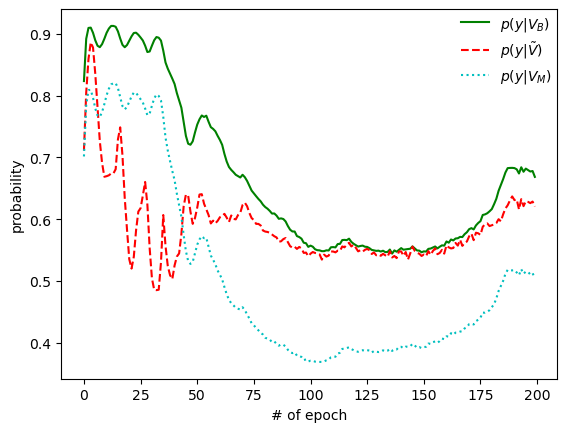

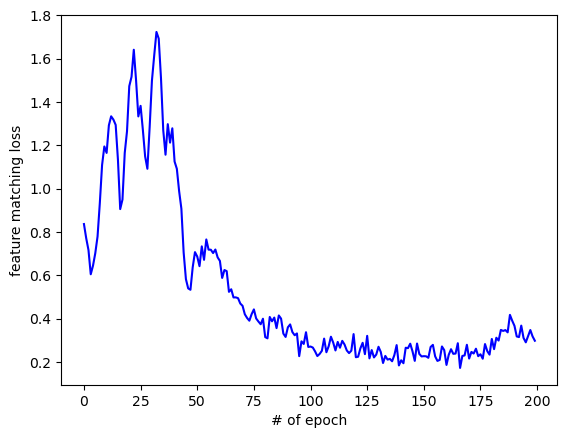

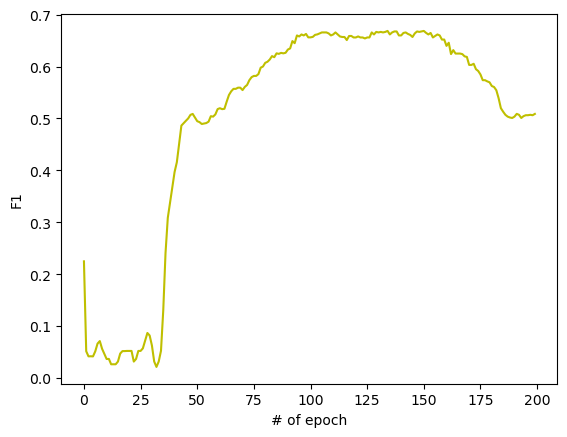

In [57]:
n_round = 200

for n_epoch in range(n_round):

    X_mb_oc = sample_shuffle_uspv(x_train)

    for n_batch in range(int(q)):

        _, D_loss_curr, ent_real_curr = sess.run([D_solver, D_loss, ent_real_loss],
                                          feed_dict={
                                                     X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                     Z: sample_Z(mb_size, Z_dim),
                                                     y_real: y_real_mb,
                                                     y_gen: y_fake_mb
                                                     })

        _, G_loss_curr, fm_loss_curr = sess.run([G_solver, G_loss, fm_loss],
                                           feed_dict={Z: sample_Z(mb_size, Z_dim),
                                                      X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                      })

    D_prob_real_, D_prob_gen_ = sess.run([D_prob_real, D_prob_gen],
                                         feed_dict={X_oc: x_train,
                                                    Z: sample_Z(len(x_train), Z_dim)})


    D_prob_vandal_ = sess.run(D_prob_real,
                              feed_dict={X_oc:x_vandal})

    d_ben_pro.append(np.mean(D_prob_real_[:, 0]))
    d_fake_pro.append(np.mean(D_prob_gen_[:, 0]))
    d_val_pro.append(np.mean(D_prob_vandal_[:, 0]))
    fm_loss_coll.append(fm_loss_curr)

    prob, _ = sess.run([D_prob_real, D_logit_real], feed_dict={X_oc: x_test})
    y_pred = np.argmax(prob, axis=1)
    y_pred_prob = prob[:,1]
    conf_mat = classification_report(y_test, y_pred, target_names=['genuine', 'fraud'], digits=4)
    f1_score.append(float(list(filter(None, conf_mat.strip().split(" ")))[12]))
    # print conf_mat


draw_trend(d_ben_pro, d_fake_pro, d_val_pro, fm_loss_coll, f1_score)

OCAN: 
              precision    recall  f1-score   support

     genuine     0.7402    0.9200    0.8204       700
       fraud     0.7228    0.3925    0.5087       372

    accuracy                         0.7369      1072
   macro avg     0.7315    0.6562    0.6645      1072
weighted avg     0.7342    0.7369    0.7122      1072

Accuracy Score:  0.7369402985074627

Linear Classifier: 
              precision    recall  f1-score   support

     genuine     0.8974    0.9963    0.9443       272
       fraud     0.9921    0.8025    0.8873       157

    accuracy                         0.9254       429
   macro avg     0.9447    0.8994    0.9158       429
weighted avg     0.9320    0.9254    0.9234       429

Accuracy Score:  0.9254079254079254


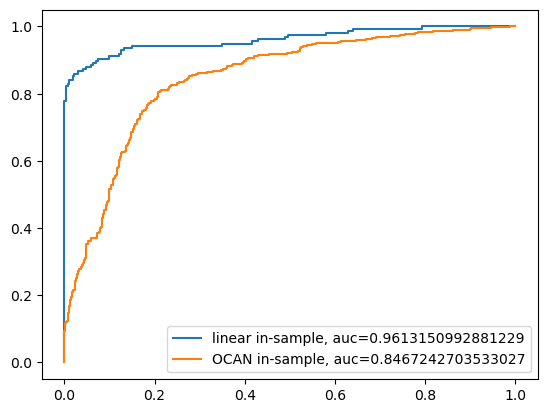

In [58]:
print ("OCAN: ")
print(conf_mat)
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))

train_x, val_x, train_y, val_y = train_test_split(x_test, y_test, test_size=0.4)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
pred_y_prob = clf.predict_proba(val_x)[:,1]

print ("")
print ("Linear Classifier: ")
print (classification_report(val_y, pred_y, target_names=['genuine', 'fraud'], digits=4))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

fpr, tpr, thresh = roc_curve(val_y, pred_y_prob)
auc = roc_auc_score(val_y, pred_y_prob)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_prob)
auc2 = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.plot(fpr2,tpr2,label="OCAN in-sample, auc="+str(auc2))
plt.legend(loc='best')
plt.show()

OCAN: 
              precision    recall  f1-score   support

     genuine     0.9989    0.9261    0.9611     71082
       fraud     0.0091    0.4000    0.0177       120

    accuracy                         0.9252     71202
   macro avg     0.5040    0.6631    0.4894     71202
weighted avg     0.9972    0.9252    0.9595     71202

Accuracy Score:  0.9252268194713632

Linear Classifier: 
              precision    recall  f1-score   support

     genuine     0.9996    0.9937    0.9966     71082
       fraud     0.1701    0.7667    0.2784       120

    accuracy                         0.9933     71202
   macro avg     0.5848    0.8802    0.6375     71202
weighted avg     0.9982    0.9933    0.9954     71202

Accuracy Score:  0.9933007499789331


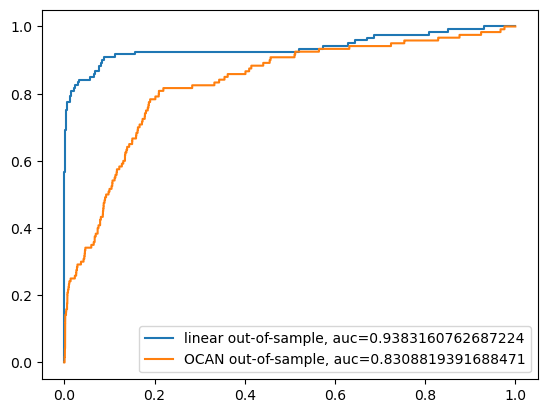

In [59]:
test_hid_rep = hidden_representation.predict(data_test.drop(['Class'], axis = 1).values)
test_y = data_test["Class"].values

prob_test, _ = sess.run([D_prob_real, D_logit_real], feed_dict={X_oc: test_hid_rep})
y_pred_test = np.argmax(prob_test, axis=1)
y_pred_prob_test = prob_test[:,1]

conf_mat_test = classification_report(test_y, y_pred_test, target_names=['genuine', 'fraud'], digits=4)
print ("OCAN: ")
print(conf_mat_test)
print ("Accuracy Score: ", accuracy_score(test_y, y_pred_test))

pred_y_test = clf.predict(test_hid_rep)
pred_y_prob_test = clf.predict_proba(test_hid_rep)[:,1]

print ("")
print ("Linear Classifier: ")
print (classification_report(test_y, pred_y_test, target_names=['genuine', 'fraud'], digits=4))
print ("Accuracy Score: ", accuracy_score(test_y, pred_y_test))

fpr, tpr, thresh = roc_curve(test_y, pred_y_prob_test)
auc = roc_auc_score(test_y, pred_y_prob_test)
fpr2, tpr2, thresh2 = roc_curve(test_y, y_pred_prob_test)
auc2 = roc_auc_score(test_y, y_pred_prob_test)
plt.plot(fpr,tpr,label="linear out-of-sample, auc="+str(auc))
plt.plot(fpr2,tpr2,label="OCAN out-of-sample, auc="+str(auc2))
plt.legend(loc='best')
plt.show()

In [60]:
import tensorflow as tf

print(tf.__version__)
# 2.5.0

2.11.0
